In [ ]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 509 kB 28.2 MB/s 


In [ ]:
import os
import shutil 
from pathlib import Path

import numpy as np 
import pandas as pd
import random

from tqdm import tqdm
import time
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau, StepLR
from torchsummary import summary

import timm

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# ====================================================
# CFG - класс с параметрами нашего эксперимента
# ====================================================
class CFG:

    num_workers=2
    model_name='resnet18' # ['resnext101_32x8d', 'inception_v3', 'densenet169', 'efficientnet_b0']
    size=224
    scheduler='StepLR' # ['StepLR', 'ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    epochs=25
    step_size = 20 # StepLR
    gamma = 0.1 # StepLR
    #factor=0.2 # ReduceLROnPlateau
    #patience=4 # ReduceLROnPlateau
    #eps=1e-6 # ReduceLROnPlateau
    #T_max=6 # CosineAnnealingLR
    #T_0=6 # CosineAnnealingWarmRestarts
    lr=1e-4 # 3e-4
    min_lr=1e-6
    batch_size=8
    seed=42
    wandb = False

In [ ]:
# Переведем наш класс с параметрами в словарь

def class2dict(f):
  return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

In [ ]:
# Зафиксируем seed для воспроизводимости

def seed_everything(seed):
    random.seed(seed) # Фиксируем генератор случайных чисел
    os.environ['PYTHONHASHSEED'] = str(seed) # Фиксируем заполнения хешей
    np.random.seed(seed) # Фиксируем генератор случайных чисел numpy
    torch.manual_seed(seed) # Фиксируем генератор случайных чисел pytorch
    torch.cuda.manual_seed(seed) # Фиксируем генератор случайных чисел для GPU
    torch.backends.cudnn.deterministic = True # Выбираем только детерминированные алгоритмы (для сверток)
    torch.backends.cudnn.benchmark = False # Фиксируем алгоритм вычисления сверток

In [ ]:
# ====================================================
# ImageFolderWithPaths - класс для создания путей до изображения
# ====================================================

class ImageFolderWithPaths(datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

# **1.** Дообучить **готовую модель resnet18** на **imagenette2** и проверить качество.

In [ ]:
# Загрузка датасета imagenette2

dataset_path = "imagenette2"
if not os.path.exists(dataset_path):
    !wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz
    !tar -xzf imagenette2.tgz

trainset_imagenette = datasets.ImageFolder(root='./%s/train/' % dataset_path, transform = transforms.Compose([transforms.Resize([224, 224]),transforms.ToTensor()]))
trainloader_imagenette = torch.utils.data.DataLoader(trainset_imagenette, batch_size=16,
                                                     shuffle=True, num_workers=2)

testset_imagenette = datasets.ImageFolder(root='./%s/val/' % dataset_path, transform = transforms.Compose([transforms.Resize([224, 224]),transforms.ToTensor()]))
testloader_imagenette = torch.utils.data.DataLoader(testset_imagenette, batch_size=128,
                                                    shuffle=False, num_workers=2)

loaders_imagenette = {'train': trainloader_imagenette, 'val': testloader_imagenette}



print('Train and Valid datasets are loaded:\n')
print('{:<7s}{:>10s}{:>10s}'.format('Dataset', 'Batches', 'Pictures'))
print('{:<7s}{:>10d}{:>10d}'.format('Train', len(trainloader_imagenette), len(trainset_imagenette)))
print('{:<7s}{:>10d}{:>10d}'.format('Valid', len(testloader_imagenette), len(testset_imagenette)))

--2022-08-09 07:24:16--  https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.243.94
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.243.94|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1557161267 (1.5G) [application/x-tar]
Saving to: ‘imagenette2.tgz’

imagenette2.tgz     100%[===================>]   1.45G  38.9MB/s    in 42s     

2022-08-09 07:24:58 (35.5 MB/s) - ‘imagenette2.tgz’ saved [1557161267/1557161267]

Train and Valid datasets are loaded:

Dataset   Batches  Pictures
Train         592      9469
Valid          31      3925


In [ ]:
def train_val_model(model, loss, optimizer, scheduler, num_epochs):
 
    loss_hist = {'train':[], 'val':[]}
    acc_hist = {'train':[], 'val':[]}
    
    best_acc = 0.

    if CFG.wandb:
        os.environ["WANDB_API_KEY"] = CFG.api
        wandb.init(project=CFG.project, name=CFG.model_name, entity=CFG.entity, reinit=True, config=class2dict(CFG))

    seed_everything(CFG.seed)

    for epoch in range(num_epochs):
        print("Epoch {}/{}:".format(epoch+1, num_epochs), end="\n")
        for phase in ['train', 'val']:
            if phase == 'train': # Если фаза == train 
                dataloader = trainloader_imagenette # Берем train_dataset
                scheduler.step() # Делаем 1 шаг (произошла одна эпоха)
                model.train()  # Модель в training mode - обучение (Фиксируем модель, иначе у нас могут изменяться параметры слоя батч-нормализации и изменится нейронка с течением времени)
            else: # Если фаза == val
                dataloader = testloader_imagenette # Берем valid_dataset 
                model.eval()   # Модель в evaluate mode - валидация (Фиксируем модель, иначе у нас могут изменяться параметры слоя батч-нормализации и изменится нейронка с течением времени)
 
            running_loss = 0. 
            running_acc = 0.
 
            # Итерируемся по dataloader
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device) # Тензор с изображениями переводим на GPU 
                labels = labels.to(device) # Тензор с лейблами переводим на GPU 
 
                optimizer.zero_grad() # Обнуляем градиент,чтобы он не накапливался 
 
                with torch.set_grad_enabled(phase == 'train'): # Если фаза train, то активируем все градиенты (те, которые не заморожены)
                    preds = model(inputs) # Считаем предикты, input передаем в модель
                    loss_value = loss(preds, labels) # Посчитали  Loss    
                    preds_class = preds.argmax(dim=1) # Получаем класс, берем .argmax(dim=1) нейрон с максимальной активацией
                
                    if phase == 'train':
                        loss_value.backward() # Считаем градиент 
                        optimizer.step() # Считаем шаг градиентного спуска
 
                # Статистика
                running_loss += loss_value.item() # Считаем Loss
                running_acc += (preds_class == labels.data).float().mean().data.cpu().numpy()  # Считаем accuracy
 
            epoch_loss = running_loss / len(dataloader)  # Loss'ы делим на кол-во бачей в эпохе 
            epoch_acc = running_acc / len(dataloader) # Считаем Loss на кол-во бачей в эпохе
            
            if CFG.wandb and phase == 'train':
              wandb.log({'train_loss': epoch_loss,
                   'train_accuracy': epoch_acc})

            if CFG.wandb and phase == 'val':
              wandb.log({'test_loss': epoch_loss,
                   'test_accuracy': epoch_acc})
               
            print("{} loss: {:.2f} accuracy: {:.2f}".format(phase, epoch_loss, epoch_acc), end="\n")

            if phase == 'val' and epoch_acc > best_acc:
              best_acc = epoch_acc
              print(f'Epoch {epoch+1} - Save Best Accuracy: {best_acc:.2f} Model\n')
              torch.save(model.state_dict(), '/content/'+f'{CFG.model_name}_best.pth')
            
            loss_hist[phase].append(epoch_loss)
            acc_hist[phase].append(epoch_acc)
        
    return model, loss_hist, acc_hist

Замораживаем веса, чтобы не использовать лишние веса в обучении, а обучать только последний слой

In [ ]:
from torchvision import models
resnet18_model = models.resnet18(pretrained=True)

# Замораживаем веса, чтобы не использовать лишние веса в обучении, а обучать только последний слой
for param in resnet18_model.parameters(): # Проходим по параметрам модели (каждый параметр - это каждый слой, model.parameters нам отдаст некоторый итератор по слоям)
    param.requires_grad = False # Для каждого параметра и слоя:"requires grad = False", то есть уже не требуется вычисление градиента для данного слоя. И получается, что у нас вся сетка будет заморожена, то есть мы не сможем вообще ничего обучать            

num_ftrs = resnet18_model.fc.in_features
num_classes_imagenette = 10
resnet18_model.fc = nn.Linear(num_ftrs, num_classes_imagenette)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18_model.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Определяем Loss функцию
# В данном случае - это кросс-энтропия (The most suitable loss function for the image classification task is categorical cross-entropy loss) 
loss = torch.nn.CrossEntropyLoss()
# Метод градиентного спуска AdamW
optimizer = torch.optim.AdamW(resnet18_model.parameters(), lr=CFG.lr) 

# Определяем разные типы изменения скорости обучения
def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
          scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='StepLR':
          scheduler = StepLR(optimizer, step_size=CFG.step_size, gamma=CFG.gamma)
        elif CFG.scheduler=='CosineAnnealingLR':
          scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
          scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

scheduler = get_scheduler(optimizer)

Дообучаем готовую модель resnet18 на imagenette2

In [ ]:
resnet18_model, loss, acc = train_val_model(resnet18_model, loss, optimizer, scheduler, num_epochs=CFG.epochs)

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch 1/25:


100%|██████████| 592/592 [01:08<00:00,  8.62it/s]


train loss: 1.23 accuracy: 0.74


100%|██████████| 31/31 [00:24<00:00,  1.29it/s]


val loss: 0.49 accuracy: 0.94
Epoch 1 - Save Best Accuracy: 0.94 Model

Epoch 2/25:


100%|██████████| 592/592 [01:03<00:00,  9.34it/s]


train loss: 0.46 accuracy: 0.93


100%|██████████| 31/31 [00:24<00:00,  1.28it/s]


val loss: 0.25 accuracy: 0.96
Epoch 2 - Save Best Accuracy: 0.96 Model

Epoch 3/25:


100%|██████████| 592/592 [01:04<00:00,  9.21it/s]


train loss: 0.30 accuracy: 0.95


100%|██████████| 31/31 [00:23<00:00,  1.30it/s]


val loss: 0.19 accuracy: 0.97
Epoch 3 - Save Best Accuracy: 0.97 Model

Epoch 4/25:


100%|██████████| 592/592 [01:04<00:00,  9.22it/s]


train loss: 0.24 accuracy: 0.95


100%|██████████| 31/31 [00:24<00:00,  1.28it/s]


val loss: 0.15 accuracy: 0.97
Epoch 4 - Save Best Accuracy: 0.97 Model

Epoch 5/25:


100%|██████████| 592/592 [01:02<00:00,  9.42it/s]


train loss: 0.21 accuracy: 0.96


100%|██████████| 31/31 [00:24<00:00,  1.24it/s]


val loss: 0.13 accuracy: 0.97
Epoch 5 - Save Best Accuracy: 0.97 Model

Epoch 6/25:


100%|██████████| 592/592 [01:01<00:00,  9.70it/s]


train loss: 0.18 accuracy: 0.96


100%|██████████| 31/31 [00:23<00:00,  1.30it/s]


val loss: 0.11 accuracy: 0.97
Epoch 6 - Save Best Accuracy: 0.97 Model

Epoch 7/25:


100%|██████████| 592/592 [01:04<00:00,  9.24it/s]


train loss: 0.16 accuracy: 0.96


100%|██████████| 31/31 [00:23<00:00,  1.30it/s]


val loss: 0.10 accuracy: 0.97
Epoch 8/25:


100%|██████████| 592/592 [01:03<00:00,  9.37it/s]


train loss: 0.15 accuracy: 0.96


100%|██████████| 31/31 [00:25<00:00,  1.24it/s]


val loss: 0.10 accuracy: 0.98
Epoch 8 - Save Best Accuracy: 0.98 Model

Epoch 9/25:


100%|██████████| 592/592 [01:02<00:00,  9.45it/s]


train loss: 0.14 accuracy: 0.96


100%|██████████| 31/31 [00:23<00:00,  1.29it/s]


val loss: 0.09 accuracy: 0.98
Epoch 9 - Save Best Accuracy: 0.98 Model

Epoch 10/25:


100%|██████████| 592/592 [01:04<00:00,  9.24it/s]


train loss: 0.14 accuracy: 0.96


100%|██████████| 31/31 [00:23<00:00,  1.29it/s]


val loss: 0.08 accuracy: 0.98
Epoch 10 - Save Best Accuracy: 0.98 Model

Epoch 11/25:


100%|██████████| 592/592 [01:03<00:00,  9.33it/s]


train loss: 0.13 accuracy: 0.96


100%|██████████| 31/31 [00:24<00:00,  1.25it/s]


val loss: 0.08 accuracy: 0.98
Epoch 12/25:


100%|██████████| 592/592 [01:03<00:00,  9.25it/s]


train loss: 0.13 accuracy: 0.96


100%|██████████| 31/31 [00:23<00:00,  1.31it/s]


val loss: 0.08 accuracy: 0.98
Epoch 13/25:


100%|██████████| 592/592 [01:04<00:00,  9.18it/s]


train loss: 0.12 accuracy: 0.97


100%|██████████| 31/31 [00:24<00:00,  1.28it/s]


val loss: 0.08 accuracy: 0.98
Epoch 14/25:


100%|██████████| 592/592 [01:02<00:00,  9.41it/s]


train loss: 0.11 accuracy: 0.97


100%|██████████| 31/31 [00:24<00:00,  1.27it/s]


val loss: 0.07 accuracy: 0.98
Epoch 14 - Save Best Accuracy: 0.98 Model

Epoch 15/25:


100%|██████████| 592/592 [01:01<00:00,  9.56it/s]


train loss: 0.12 accuracy: 0.97


100%|██████████| 31/31 [00:24<00:00,  1.29it/s]


val loss: 0.07 accuracy: 0.98
Epoch 15 - Save Best Accuracy: 0.98 Model

Epoch 16/25:


100%|██████████| 592/592 [01:02<00:00,  9.51it/s]


train loss: 0.11 accuracy: 0.97


100%|██████████| 31/31 [00:24<00:00,  1.29it/s]


val loss: 0.07 accuracy: 0.98
Epoch 17/25:


100%|██████████| 592/592 [01:03<00:00,  9.27it/s]


train loss: 0.11 accuracy: 0.97


100%|██████████| 31/31 [00:23<00:00,  1.30it/s]


val loss: 0.07 accuracy: 0.98
Epoch 18/25:


100%|██████████| 592/592 [01:02<00:00,  9.44it/s]


train loss: 0.11 accuracy: 0.97


100%|██████████| 31/31 [00:24<00:00,  1.28it/s]


val loss: 0.06 accuracy: 0.98
Epoch 19/25:


100%|██████████| 592/592 [01:02<00:00,  9.53it/s]


train loss: 0.10 accuracy: 0.97


100%|██████████| 31/31 [00:23<00:00,  1.30it/s]


val loss: 0.06 accuracy: 0.98
Epoch 20/25:


100%|██████████| 592/592 [01:03<00:00,  9.31it/s]


train loss: 0.10 accuracy: 0.97


100%|██████████| 31/31 [00:23<00:00,  1.30it/s]


val loss: 0.07 accuracy: 0.98
Epoch 21/25:


100%|██████████| 592/592 [01:02<00:00,  9.46it/s]


train loss: 0.10 accuracy: 0.97


100%|██████████| 31/31 [00:23<00:00,  1.30it/s]


val loss: 0.06 accuracy: 0.98
Epoch 22/25:


100%|██████████| 592/592 [01:04<00:00,  9.21it/s]


train loss: 0.10 accuracy: 0.97


100%|██████████| 31/31 [00:23<00:00,  1.29it/s]


val loss: 0.06 accuracy: 0.98
Epoch 23/25:


100%|██████████| 592/592 [01:03<00:00,  9.27it/s]


train loss: 0.10 accuracy: 0.97


100%|██████████| 31/31 [00:23<00:00,  1.30it/s]


val loss: 0.06 accuracy: 0.98
Epoch 23 - Save Best Accuracy: 0.98 Model

Epoch 24/25:


100%|██████████| 592/592 [01:02<00:00,  9.47it/s]


train loss: 0.10 accuracy: 0.97


100%|██████████| 31/31 [00:24<00:00,  1.29it/s]


val loss: 0.06 accuracy: 0.98
Epoch 25/25:


100%|██████████| 592/592 [01:04<00:00,  9.17it/s]


train loss: 0.10 accuracy: 0.97


100%|██████████| 31/31 [00:23<00:00,  1.30it/s]

val loss: 0.06 accuracy: 0.98


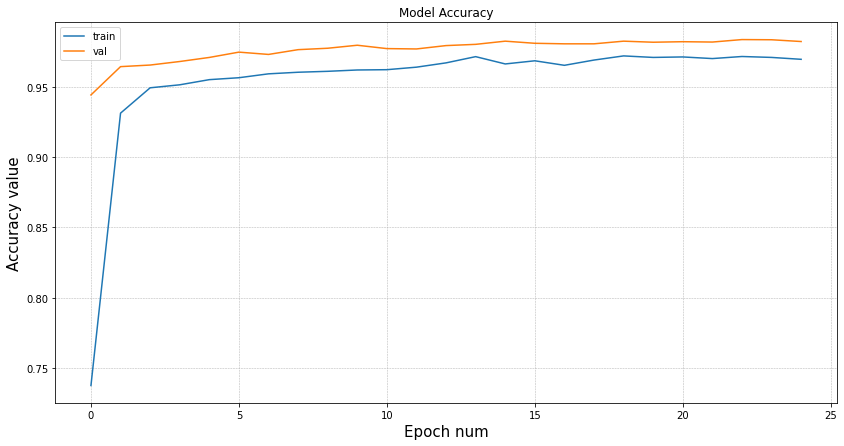

In [ ]:
plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in acc.keys():
    plt.plot(acc[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Accuracy')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Accuracy value', fontsize=15);
plt.grid(linestyle='--', linewidth=0.5, color='.7')

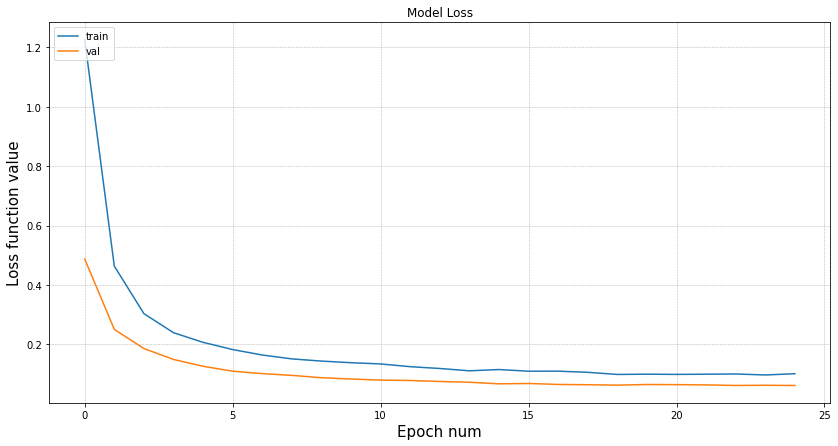

In [ ]:
plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in loss.keys():
    plt.plot(loss[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Loss')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Loss function value', fontsize=15)
plt.grid(linestyle='--', linewidth=0.5, color='.7')

Сохраняем последний слой в переменную **imagenette_fc** и создаем новый слой взамен imagenette_fc 

In [ ]:
imagenette_fc = resnet18_model.fc
num_ftrs = resnet18_model.fc.in_features
num_classes_cifar10 = 10
resnet18_model.fc = nn.Linear(num_ftrs, num_classes_cifar10)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18_model = resnet18_model.to(device)

Повторяем ф-цию **train_val_model**, только добавляем два параметра: **dataldr_train, dataldr_val**, они относятся к датасету **CIFAR10** (см. ниже)

In [ ]:
def train_val_model_dl(model, loss, optimizer, scheduler, num_epochs, dataldr_train, dataldr_val):
 
    loss_hist = {'train':[], 'val':[]}
    acc_hist = {'train':[], 'val':[]}
    
    best_acc = 0.

    if CFG.wandb:
        os.environ["WANDB_API_KEY"] = CFG.api
        wandb.init(project=CFG.project, name=CFG.model_name, entity=CFG.entity, reinit=True, config=class2dict(CFG))

    seed_everything(CFG.seed)

    for epoch in range(num_epochs):
        print("Epoch {}/{}:".format(epoch+1, num_epochs), end="\n")
        for phase in ['train', 'val']:
            if phase == 'train': # Если фаза == train 
                dataloader = dataldr_train # Берем train_dataset
                scheduler.step() # Делаем 1 шаг (произошла одна эпоха)
                model.train()  # Модель в training mode - обучение (Фиксируем модель, иначе у нас могут изменяться параметры слоя батч-нормализации и изменится нейронка с течением времени)
            else: # Если фаза == val
                dataloader = dataldr_val # Берем valid_dataset 
                model.eval()   # Модель в evaluate mode - валидация (Фиксируем модель, иначе у нас могут изменяться параметры слоя батч-нормализации и изменится нейронка с течением времени)
 
            running_loss = 0. 
            running_acc = 0.
 
            # Итерируемся по dataloader
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device) # Тензор с изображениями переводим на GPU 
                labels = labels.to(device) # Тензор с лейблами переводим на GPU 
 
                optimizer.zero_grad() # Обнуляем градиент,чтобы он не накапливался 
 
                with torch.set_grad_enabled(phase == 'train'): # Если фаза train, то активируем все градиенты (те, которые не заморожены)
                    preds = model(inputs) # Считаем предикты, input передаем в модель
                    loss_value = loss(preds, labels) # Посчитали  Loss    
                    preds_class = preds.argmax(dim=1) # Получаем класс, берем .argmax(dim=1) нейрон с максимальной активацией
                
                    if phase == 'train':
                        loss_value.backward() # Считаем градиент 
                        optimizer.step() # Считаем шаг градиентного спуска
 
                # Статистика
                running_loss += loss_value.item() # Считаем Loss
                running_acc += (preds_class == labels.data).float().mean().data.cpu().numpy()  # Считаем accuracy
 
            epoch_loss = running_loss / len(dataloader)  # Loss'ы делим на кол-во бачей в эпохе 
            epoch_acc = running_acc / len(dataloader) # Считаем Loss на кол-во бачей в эпохе
            
            if CFG.wandb and phase == 'train':
              wandb.log({'train_loss': epoch_loss,
                   'train_accuracy': epoch_acc})

            if CFG.wandb and phase == 'val':
              wandb.log({'test_loss': epoch_loss,
                   'test_accuracy': epoch_acc})
               
            print("{} loss: {:.2f} accuracy: {:.2f}".format(phase, epoch_loss, epoch_acc), end="\n")

            if phase == 'val' and epoch_acc > best_acc:
              best_acc = epoch_acc
              print(f'Epoch {epoch+1} - Save Best Accuracy: {best_acc:.2f} Model\n')
              torch.save(model.state_dict(), '/content/'+f'{CFG.model_name}_best.pth')
            
            loss_hist[phase].append(epoch_loss)
            acc_hist[phase].append(epoch_acc)
        
    return model, loss_hist, acc_hist

Загружаем датасет "CIFAR10"

In [ ]:
dataset_path = "CIFAR10"
if not os.path.exists(dataset_path):

    cifar_train_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10('./%s/train/' % dataset_path, train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])), batch_size=16, shuffle=True, num_workers=2)
    
    cifar_test_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root='./%s/val/' % dataset_path, train=False, download=True, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])), batch_size=128, shuffle=False, num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./CIFAR10/train/cifar-10-python.tar.gz to ./CIFAR10/train/


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./CIFAR10/val/cifar-10-python.tar.gz to ./CIFAR10/val/


Обучаемся на "CIFAR10"

In [ ]:
resnet18_model, loss, acc = train_val_model_dl(resnet18_model, loss, optimizer, scheduler, CFG.epochs, cifar_train_loader, cifar_test_loader)

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch 1/25:


100%|██████████| 3125/3125 [00:33<00:00, 94.54it/s]


train loss: 1.97 accuracy: 0.30


100%|██████████| 79/79 [00:02<00:00, 32.60it/s]


val loss: 1.78 accuracy: 0.38
Epoch 1 - Save Best Accuracy: 0.38 Model

Epoch 2/25:


100%|██████████| 3125/3125 [00:32<00:00, 94.75it/s]


train loss: 1.73 accuracy: 0.39


100%|██████████| 79/79 [00:02<00:00, 33.68it/s]


val loss: 1.69 accuracy: 0.43
Epoch 2 - Save Best Accuracy: 0.43 Model

Epoch 3/25:


100%|██████████| 3125/3125 [00:33<00:00, 93.46it/s]


train loss: 1.67 accuracy: 0.41


100%|██████████| 79/79 [00:02<00:00, 33.24it/s]


val loss: 1.64 accuracy: 0.44
Epoch 3 - Save Best Accuracy: 0.44 Model

Epoch 4/25:


100%|██████████| 3125/3125 [00:32<00:00, 95.91it/s]


train loss: 1.66 accuracy: 0.41


100%|██████████| 79/79 [00:02<00:00, 33.72it/s]


val loss: 1.63 accuracy: 0.44
Epoch 4 - Save Best Accuracy: 0.44 Model

Epoch 5/25:


100%|██████████| 3125/3125 [00:33<00:00, 93.18it/s]


train loss: 1.64 accuracy: 0.42


100%|██████████| 79/79 [00:02<00:00, 33.10it/s]


val loss: 1.60 accuracy: 0.45
Epoch 5 - Save Best Accuracy: 0.45 Model

Epoch 6/25:


100%|██████████| 3125/3125 [00:33<00:00, 94.39it/s]


train loss: 1.63 accuracy: 0.42


100%|██████████| 79/79 [00:02<00:00, 28.95it/s]


val loss: 1.59 accuracy: 0.45
Epoch 6 - Save Best Accuracy: 0.45 Model

Epoch 7/25:


100%|██████████| 3125/3125 [00:32<00:00, 95.38it/s]


train loss: 1.63 accuracy: 0.43


100%|██████████| 79/79 [00:02<00:00, 33.64it/s]


val loss: 1.61 accuracy: 0.45
Epoch 7 - Save Best Accuracy: 0.45 Model

Epoch 8/25:


100%|██████████| 3125/3125 [00:32<00:00, 95.54it/s]


train loss: 1.62 accuracy: 0.43


100%|██████████| 79/79 [00:02<00:00, 33.53it/s]


val loss: 1.60 accuracy: 0.45
Epoch 8 - Save Best Accuracy: 0.45 Model

Epoch 9/25:


100%|██████████| 3125/3125 [00:32<00:00, 95.09it/s]


train loss: 1.62 accuracy: 0.43


100%|██████████| 79/79 [00:02<00:00, 31.88it/s]


val loss: 1.59 accuracy: 0.45
Epoch 10/25:


100%|██████████| 3125/3125 [00:33<00:00, 93.49it/s]


train loss: 1.61 accuracy: 0.43


100%|██████████| 79/79 [00:02<00:00, 31.14it/s]


val loss: 1.59 accuracy: 0.45
Epoch 10 - Save Best Accuracy: 0.45 Model

Epoch 11/25:


100%|██████████| 3125/3125 [00:32<00:00, 95.25it/s]


train loss: 1.61 accuracy: 0.43


100%|██████████| 79/79 [00:02<00:00, 33.37it/s]


val loss: 1.59 accuracy: 0.45
Epoch 12/25:


100%|██████████| 3125/3125 [00:32<00:00, 95.74it/s]


train loss: 1.61 accuracy: 0.43


100%|██████████| 79/79 [00:02<00:00, 33.68it/s]


val loss: 1.59 accuracy: 0.46
Epoch 12 - Save Best Accuracy: 0.46 Model

Epoch 13/25:


100%|██████████| 3125/3125 [00:32<00:00, 95.47it/s]


train loss: 1.62 accuracy: 0.43


100%|██████████| 79/79 [00:02<00:00, 33.18it/s]


val loss: 1.58 accuracy: 0.46
Epoch 13 - Save Best Accuracy: 0.46 Model

Epoch 14/25:


100%|██████████| 3125/3125 [00:33<00:00, 92.53it/s]


train loss: 1.61 accuracy: 0.43


100%|██████████| 79/79 [00:02<00:00, 32.92it/s]


val loss: 1.57 accuracy: 0.46
Epoch 15/25:


100%|██████████| 3125/3125 [00:32<00:00, 94.82it/s]


train loss: 1.60 accuracy: 0.43


100%|██████████| 79/79 [00:02<00:00, 33.22it/s]


val loss: 1.56 accuracy: 0.46
Epoch 15 - Save Best Accuracy: 0.46 Model

Epoch 16/25:


100%|██████████| 3125/3125 [00:32<00:00, 95.32it/s]


train loss: 1.61 accuracy: 0.43


100%|██████████| 79/79 [00:02<00:00, 33.06it/s]


val loss: 1.57 accuracy: 0.47
Epoch 16 - Save Best Accuracy: 0.47 Model

Epoch 17/25:


100%|██████████| 3125/3125 [00:33<00:00, 93.73it/s]


train loss: 1.60 accuracy: 0.44


100%|██████████| 79/79 [00:02<00:00, 29.34it/s]


val loss: 1.58 accuracy: 0.46
Epoch 18/25:


100%|██████████| 3125/3125 [00:33<00:00, 93.68it/s]


train loss: 1.61 accuracy: 0.43


100%|██████████| 79/79 [00:02<00:00, 32.54it/s]


val loss: 1.56 accuracy: 0.46
Epoch 19/25:


100%|██████████| 3125/3125 [00:33<00:00, 94.09it/s]


train loss: 1.60 accuracy: 0.44


100%|██████████| 79/79 [00:02<00:00, 33.26it/s]


val loss: 1.57 accuracy: 0.46
Epoch 20/25:


100%|██████████| 3125/3125 [00:33<00:00, 94.16it/s]


train loss: 1.59 accuracy: 0.44


100%|██████████| 79/79 [00:02<00:00, 32.36it/s]


val loss: 1.58 accuracy: 0.47
Epoch 21/25:


100%|██████████| 3125/3125 [00:33<00:00, 91.97it/s]


train loss: 1.60 accuracy: 0.44


100%|██████████| 79/79 [00:02<00:00, 31.97it/s]


val loss: 1.59 accuracy: 0.45
Epoch 22/25:


100%|██████████| 3125/3125 [00:33<00:00, 92.64it/s]


train loss: 1.59 accuracy: 0.44


100%|██████████| 79/79 [00:02<00:00, 32.01it/s]


val loss: 1.56 accuracy: 0.47
Epoch 22 - Save Best Accuracy: 0.47 Model

Epoch 23/25:


100%|██████████| 3125/3125 [00:33<00:00, 94.67it/s]


train loss: 1.59 accuracy: 0.44


100%|██████████| 79/79 [00:02<00:00, 33.06it/s]


val loss: 1.56 accuracy: 0.46
Epoch 24/25:


100%|██████████| 3125/3125 [00:32<00:00, 94.94it/s]


train loss: 1.59 accuracy: 0.44


100%|██████████| 79/79 [00:02<00:00, 33.41it/s]


val loss: 1.58 accuracy: 0.46
Epoch 25/25:


100%|██████████| 3125/3125 [00:33<00:00, 92.32it/s]


train loss: 1.59 accuracy: 0.44


100%|██████████| 79/79 [00:02<00:00, 32.40it/s]

val loss: 1.58 accuracy: 0.46


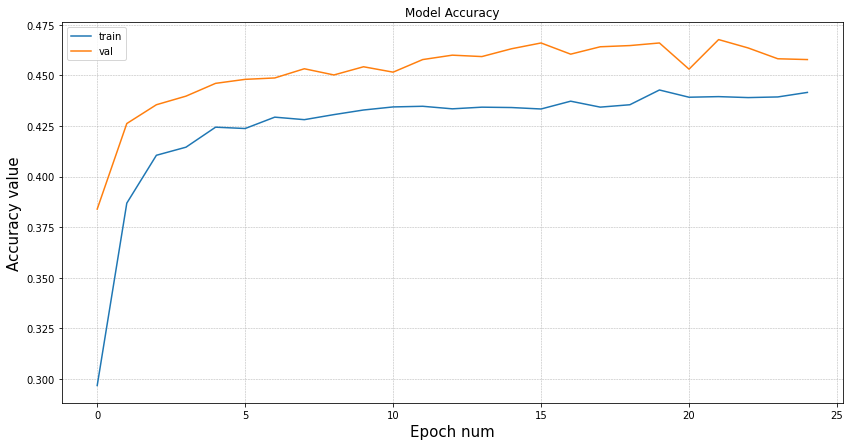

In [ ]:
plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in acc.keys():
    plt.plot(acc[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Accuracy')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Accuracy value', fontsize=15);
plt.grid(linestyle='--', linewidth=0.5, color='.7')

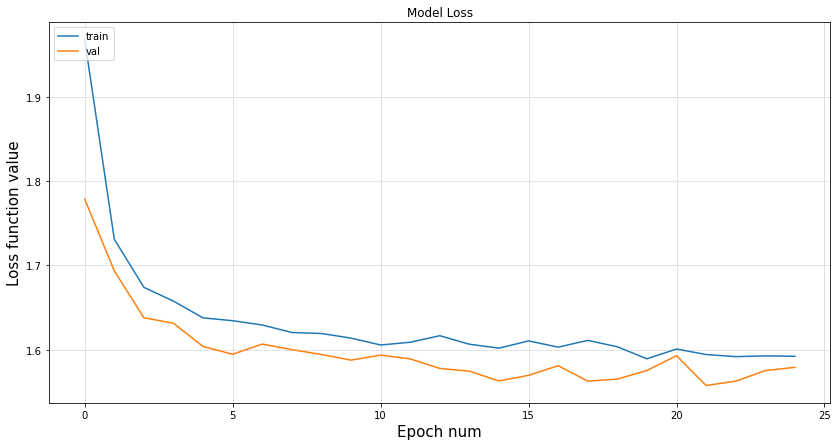

In [ ]:
plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in loss.keys():
    plt.plot(loss[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Loss')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Loss function value', fontsize=15)
plt.grid(linestyle='--', linewidth=0.5, color='.7')

Размораживаем веса и снова обучаемся на "CIFAR10"

In [ ]:
# Размораживаем веса
for param in resnet18_model.parameters(): # Проходим по параметрам модели (каждый параметр - это каждый слой, model.parameters нам отдаст некоторый итератор по слоям)
    param.requires_grad = True

In [ ]:
resnet18_model, loss, acc = train_val_model_dl(resnet18_model, loss, optimizer, scheduler, CFG.epochs, cifar_train_loader, cifar_test_loader)

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch 1/25:


100%|██████████| 3125/3125 [01:22<00:00, 37.67it/s]


train loss: 1.08 accuracy: 0.63


100%|██████████| 79/79 [00:02<00:00, 31.51it/s]


val loss: 0.74 accuracy: 0.75
Epoch 1 - Save Best Accuracy: 0.75 Model

Epoch 2/25:


100%|██████████| 3125/3125 [01:22<00:00, 38.07it/s]


train loss: 0.74 accuracy: 0.75


100%|██████████| 79/79 [00:02<00:00, 27.89it/s]


val loss: 0.65 accuracy: 0.78
Epoch 2 - Save Best Accuracy: 0.78 Model

Epoch 3/25:


100%|██████████| 3125/3125 [01:21<00:00, 38.15it/s]


train loss: 0.60 accuracy: 0.80


100%|██████████| 79/79 [00:02<00:00, 32.10it/s]


val loss: 0.57 accuracy: 0.81
Epoch 3 - Save Best Accuracy: 0.81 Model

Epoch 4/25:


100%|██████████| 3125/3125 [01:23<00:00, 37.49it/s]


train loss: 0.48 accuracy: 0.84


100%|██████████| 79/79 [00:02<00:00, 31.18it/s]


val loss: 0.54 accuracy: 0.82
Epoch 4 - Save Best Accuracy: 0.82 Model

Epoch 5/25:


100%|██████████| 3125/3125 [01:23<00:00, 37.50it/s]


train loss: 0.38 accuracy: 0.87


100%|██████████| 79/79 [00:02<00:00, 31.22it/s]


val loss: 0.57 accuracy: 0.81
Epoch 6/25:


100%|██████████| 3125/3125 [01:23<00:00, 37.31it/s]


train loss: 0.31 accuracy: 0.89


100%|██████████| 79/79 [00:02<00:00, 31.27it/s]


val loss: 0.54 accuracy: 0.82
Epoch 6 - Save Best Accuracy: 0.82 Model

Epoch 7/25:


100%|██████████| 3125/3125 [01:23<00:00, 37.39it/s]


train loss: 0.25 accuracy: 0.91


100%|██████████| 79/79 [00:02<00:00, 32.34it/s]


val loss: 0.57 accuracy: 0.82
Epoch 8/25:


100%|██████████| 3125/3125 [01:22<00:00, 38.05it/s]


train loss: 0.21 accuracy: 0.93


100%|██████████| 79/79 [00:02<00:00, 31.57it/s]


val loss: 0.59 accuracy: 0.82
Epoch 9/25:


100%|██████████| 3125/3125 [01:23<00:00, 37.51it/s]


train loss: 0.17 accuracy: 0.94


100%|██████████| 79/79 [00:02<00:00, 32.00it/s]


val loss: 0.60 accuracy: 0.82
Epoch 10/25:


100%|██████████| 3125/3125 [01:22<00:00, 37.68it/s]


train loss: 0.14 accuracy: 0.95


100%|██████████| 79/79 [00:02<00:00, 31.24it/s]


val loss: 0.61 accuracy: 0.82
Epoch 11/25:


100%|██████████| 3125/3125 [01:22<00:00, 38.00it/s]


train loss: 0.13 accuracy: 0.96


100%|██████████| 79/79 [00:02<00:00, 30.66it/s]


val loss: 0.66 accuracy: 0.82
Epoch 12/25:


100%|██████████| 3125/3125 [01:22<00:00, 38.02it/s]


train loss: 0.12 accuracy: 0.96


100%|██████████| 79/79 [00:02<00:00, 31.76it/s]


val loss: 0.66 accuracy: 0.81
Epoch 13/25:


100%|██████████| 3125/3125 [01:22<00:00, 37.82it/s]


train loss: 0.10 accuracy: 0.97


100%|██████████| 79/79 [00:02<00:00, 31.99it/s]


val loss: 0.63 accuracy: 0.83
Epoch 13 - Save Best Accuracy: 0.83 Model

Epoch 14/25:


100%|██████████| 3125/3125 [01:21<00:00, 38.13it/s]


train loss: 0.09 accuracy: 0.97


100%|██████████| 79/79 [00:02<00:00, 31.23it/s]


val loss: 0.66 accuracy: 0.83
Epoch 14 - Save Best Accuracy: 0.83 Model

Epoch 15/25:


100%|██████████| 3125/3125 [01:23<00:00, 37.57it/s]


train loss: 0.09 accuracy: 0.97


100%|██████████| 79/79 [00:02<00:00, 30.82it/s]


val loss: 0.67 accuracy: 0.82
Epoch 16/25:


100%|██████████| 3125/3125 [01:23<00:00, 37.27it/s]


train loss: 0.08 accuracy: 0.97


100%|██████████| 79/79 [00:02<00:00, 31.21it/s]


val loss: 0.64 accuracy: 0.83
Epoch 16 - Save Best Accuracy: 0.83 Model

Epoch 17/25:


100%|██████████| 3125/3125 [01:23<00:00, 37.56it/s]


train loss: 0.08 accuracy: 0.97


100%|██████████| 79/79 [00:02<00:00, 31.74it/s]


val loss: 0.69 accuracy: 0.82
Epoch 18/25:


100%|██████████| 3125/3125 [01:22<00:00, 37.92it/s]


train loss: 0.07 accuracy: 0.98


100%|██████████| 79/79 [00:02<00:00, 31.49it/s]


val loss: 0.71 accuracy: 0.82
Epoch 19/25:


100%|██████████| 3125/3125 [01:22<00:00, 37.94it/s]


train loss: 0.07 accuracy: 0.98


100%|██████████| 79/79 [00:02<00:00, 32.45it/s]


val loss: 0.71 accuracy: 0.82
Epoch 20/25:


100%|██████████| 3125/3125 [01:22<00:00, 37.89it/s]


train loss: 0.03 accuracy: 0.99


100%|██████████| 79/79 [00:02<00:00, 32.00it/s]


val loss: 0.66 accuracy: 0.84
Epoch 20 - Save Best Accuracy: 0.84 Model

Epoch 21/25:


100%|██████████| 3125/3125 [01:21<00:00, 38.13it/s]


train loss: 0.02 accuracy: 1.00


100%|██████████| 79/79 [00:02<00:00, 31.87it/s]


val loss: 0.67 accuracy: 0.84
Epoch 21 - Save Best Accuracy: 0.84 Model

Epoch 22/25:


100%|██████████| 3125/3125 [01:21<00:00, 38.13it/s]


train loss: 0.01 accuracy: 1.00


100%|██████████| 79/79 [00:02<00:00, 32.38it/s]


val loss: 0.70 accuracy: 0.84
Epoch 22 - Save Best Accuracy: 0.84 Model

Epoch 23/25:


100%|██████████| 3125/3125 [01:21<00:00, 38.29it/s]


train loss: 0.01 accuracy: 1.00


100%|██████████| 79/79 [00:02<00:00, 32.54it/s]


val loss: 0.72 accuracy: 0.84
Epoch 23 - Save Best Accuracy: 0.84 Model

Epoch 24/25:


100%|██████████| 3125/3125 [01:22<00:00, 38.08it/s]


train loss: 0.01 accuracy: 1.00


100%|██████████| 79/79 [00:02<00:00, 32.31it/s]


val loss: 0.74 accuracy: 0.84
Epoch 25/25:


100%|██████████| 3125/3125 [01:21<00:00, 38.21it/s]


train loss: 0.01 accuracy: 1.00


100%|██████████| 79/79 [00:02<00:00, 32.16it/s]

val loss: 0.72 accuracy: 0.84


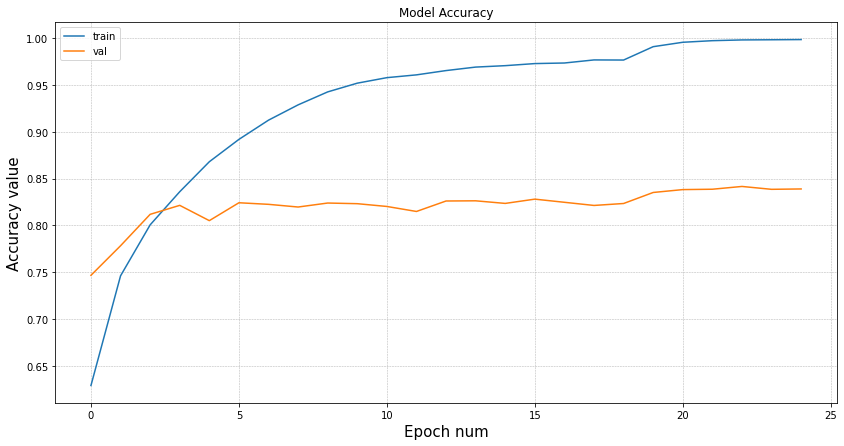

In [ ]:
plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in acc.keys():
    plt.plot(acc[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Accuracy')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Accuracy value', fontsize=15);
plt.grid(linestyle='--', linewidth=0.5, color='.7')

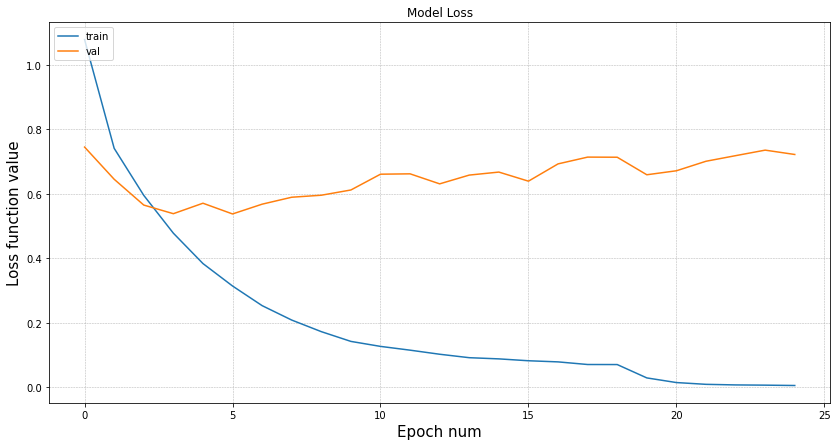

In [ ]:
plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in loss.keys():
    plt.plot(loss[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Loss')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Loss function value', fontsize=15)
plt.grid(linestyle='--', linewidth=0.5, color='.7')

Убираем последий полносвязанный слой и прикручиваем предыдущий (из переменной imagenette_fc) и проверяем метрики опять на imagenette

In [ ]:
num_ftrs = resnet18_model.fc.in_features
num_classes_imagenette = 10
resnet18_model.fc = imagenette_fc


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

resnet18_model = resnet18_model.to(device)

In [ ]:
resnet18_model, loss, acc = train_val_model(resnet18_model, loss, optimizer, scheduler, num_epochs=CFG.epochs)

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch 1/25:


100%|██████████| 592/592 [01:11<00:00,  8.31it/s]


train loss: 0.54 accuracy: 0.82


100%|██████████| 31/31 [00:25<00:00,  1.21it/s]


val loss: 0.37 accuracy: 0.88
Epoch 1 - Save Best Accuracy: 0.88 Model

Epoch 2/25:


100%|██████████| 592/592 [01:10<00:00,  8.37it/s]


train loss: 0.18 accuracy: 0.94


100%|██████████| 31/31 [00:23<00:00,  1.29it/s]


val loss: 0.31 accuracy: 0.90
Epoch 2 - Save Best Accuracy: 0.90 Model

Epoch 3/25:


100%|██████████| 592/592 [01:10<00:00,  8.43it/s]


train loss: 0.08 accuracy: 0.98


100%|██████████| 31/31 [00:23<00:00,  1.30it/s]


val loss: 0.31 accuracy: 0.92
Epoch 3 - Save Best Accuracy: 0.92 Model

Epoch 4/25:


100%|██████████| 592/592 [01:10<00:00,  8.44it/s]


train loss: 0.06 accuracy: 0.98


100%|██████████| 31/31 [00:23<00:00,  1.31it/s]


val loss: 0.40 accuracy: 0.90
Epoch 5/25:


100%|██████████| 592/592 [01:08<00:00,  8.61it/s]


train loss: 0.06 accuracy: 0.98


100%|██████████| 31/31 [00:23<00:00,  1.31it/s]


val loss: 0.38 accuracy: 0.90
Epoch 6/25:


100%|██████████| 592/592 [01:09<00:00,  8.49it/s]


train loss: 0.05 accuracy: 0.98


100%|██████████| 31/31 [00:23<00:00,  1.32it/s]


val loss: 0.36 accuracy: 0.90
Epoch 7/25:


100%|██████████| 592/592 [01:09<00:00,  8.54it/s]


train loss: 0.03 accuracy: 0.99


100%|██████████| 31/31 [00:23<00:00,  1.30it/s]


val loss: 0.33 accuracy: 0.91
Epoch 8/25:


100%|██████████| 592/592 [01:09<00:00,  8.58it/s]


train loss: 0.03 accuracy: 0.99


100%|██████████| 31/31 [00:24<00:00,  1.26it/s]


val loss: 0.38 accuracy: 0.90
Epoch 9/25:


100%|██████████| 592/592 [01:08<00:00,  8.61it/s]


train loss: 0.04 accuracy: 0.99


100%|██████████| 31/31 [00:23<00:00,  1.31it/s]


val loss: 0.42 accuracy: 0.90
Epoch 10/25:


100%|██████████| 592/592 [01:09<00:00,  8.56it/s]


train loss: 0.03 accuracy: 0.99


100%|██████████| 31/31 [00:23<00:00,  1.31it/s]


val loss: 0.33 accuracy: 0.92
Epoch 10 - Save Best Accuracy: 0.92 Model

Epoch 11/25:


100%|██████████| 592/592 [01:09<00:00,  8.47it/s]


train loss: 0.03 accuracy: 0.99


100%|██████████| 31/31 [00:23<00:00,  1.31it/s]


val loss: 0.33 accuracy: 0.91
Epoch 12/25:


100%|██████████| 592/592 [01:08<00:00,  8.61it/s]


train loss: 0.03 accuracy: 0.99


100%|██████████| 31/31 [00:24<00:00,  1.26it/s]


val loss: 0.32 accuracy: 0.92
Epoch 13/25:


100%|██████████| 592/592 [01:09<00:00,  8.48it/s]


train loss: 0.02 accuracy: 0.99


100%|██████████| 31/31 [00:23<00:00,  1.31it/s]


val loss: 0.43 accuracy: 0.91
Epoch 14/25:


100%|██████████| 592/592 [01:09<00:00,  8.51it/s]


train loss: 0.03 accuracy: 0.99


100%|██████████| 31/31 [00:23<00:00,  1.32it/s]


val loss: 0.35 accuracy: 0.92
Epoch 15/25:


100%|██████████| 592/592 [01:09<00:00,  8.51it/s]


train loss: 0.02 accuracy: 0.99


100%|██████████| 31/31 [00:23<00:00,  1.31it/s]


val loss: 0.45 accuracy: 0.90
Epoch 16/25:


100%|██████████| 592/592 [01:08<00:00,  8.62it/s]


train loss: 0.02 accuracy: 0.99


100%|██████████| 31/31 [00:23<00:00,  1.31it/s]


val loss: 0.36 accuracy: 0.92
Epoch 17/25:


100%|██████████| 592/592 [01:08<00:00,  8.60it/s]


train loss: 0.02 accuracy: 0.99


100%|██████████| 31/31 [00:23<00:00,  1.30it/s]


val loss: 0.36 accuracy: 0.91
Epoch 18/25:


100%|██████████| 592/592 [01:10<00:00,  8.38it/s]


train loss: 0.02 accuracy: 0.99


100%|██████████| 31/31 [00:23<00:00,  1.30it/s]


val loss: 0.41 accuracy: 0.91
Epoch 19/25:


100%|██████████| 592/592 [01:09<00:00,  8.56it/s]


train loss: 0.02 accuracy: 0.99


100%|██████████| 31/31 [00:24<00:00,  1.27it/s]


val loss: 0.38 accuracy: 0.91
Epoch 20/25:


100%|██████████| 592/592 [01:08<00:00,  8.66it/s]


train loss: 0.01 accuracy: 1.00


100%|██████████| 31/31 [00:23<00:00,  1.31it/s]


val loss: 0.33 accuracy: 0.92
Epoch 20 - Save Best Accuracy: 0.92 Model

Epoch 21/25:


100%|██████████| 592/592 [01:09<00:00,  8.48it/s]


train loss: 0.00 accuracy: 1.00


100%|██████████| 31/31 [00:23<00:00,  1.31it/s]


val loss: 0.32 accuracy: 0.92
Epoch 22/25:


100%|██████████| 592/592 [01:09<00:00,  8.54it/s]


train loss: 0.00 accuracy: 1.00


100%|██████████| 31/31 [00:23<00:00,  1.31it/s]


val loss: 0.30 accuracy: 0.93
Epoch 22 - Save Best Accuracy: 0.93 Model

Epoch 23/25:


100%|██████████| 592/592 [01:09<00:00,  8.57it/s]


train loss: 0.00 accuracy: 1.00


100%|██████████| 31/31 [00:24<00:00,  1.27it/s]


val loss: 0.30 accuracy: 0.93
Epoch 23 - Save Best Accuracy: 0.93 Model

Epoch 24/25:


100%|██████████| 592/592 [01:07<00:00,  8.71it/s]


train loss: 0.00 accuracy: 1.00


100%|██████████| 31/31 [00:23<00:00,  1.32it/s]


val loss: 0.31 accuracy: 0.92
Epoch 25/25:


100%|██████████| 592/592 [01:08<00:00,  8.58it/s]


train loss: 0.00 accuracy: 1.00


100%|██████████| 31/31 [00:23<00:00,  1.31it/s]

val loss: 0.31 accuracy: 0.93


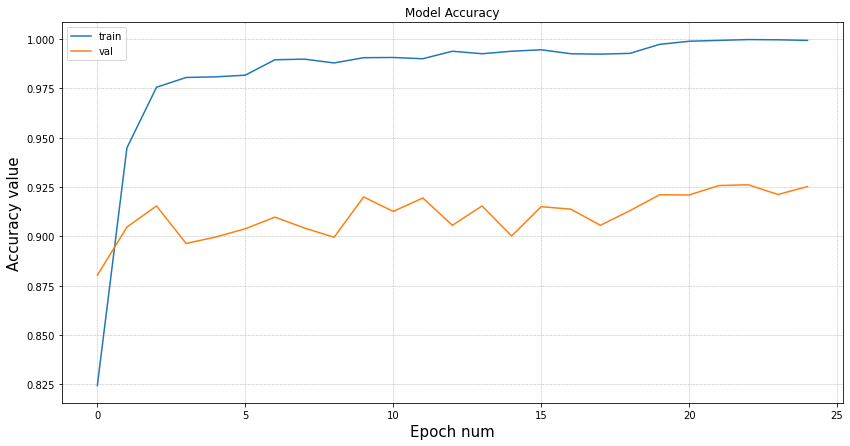

In [ ]:
plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in acc.keys():
    plt.plot(acc[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Accuracy')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Accuracy value', fontsize=15);
plt.grid(linestyle='--', linewidth=0.5, color='.7')

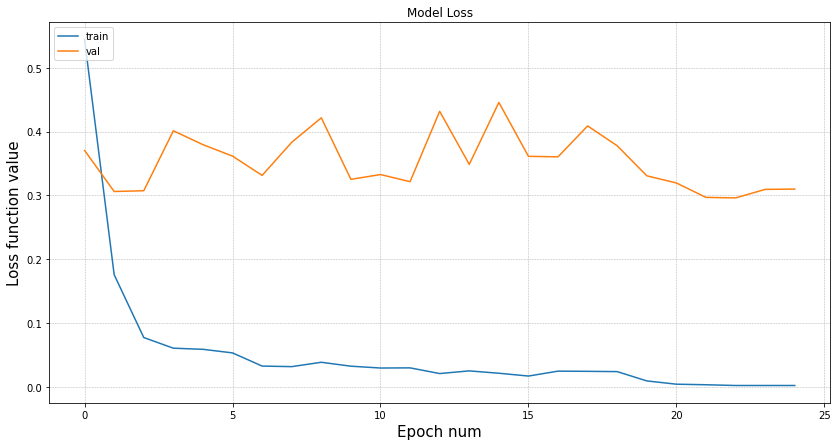

In [ ]:
plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in loss.keys():
    plt.plot(loss[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Loss')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Loss function value', fontsize=15)
plt.grid(linestyle='--', linewidth=0.5, color='.7')